# 171^Yb+ ion qubit simulation rough layout and first introduction
---
I wanted to create a realistic simulation of the ion and perform actual operations on it. My idea was to use physical units making it as "real" as possible. I also wanted to use what we learned in the beginning of the course in addition to some of the knowledge of other courses I took (like Scientific computing for ordinary and partial differential equations). 

I chose a class based approach, also to learn how to work with them. I made the following classes:
- IonQubit / YbQubit      |  defining the energy levels some hamiltonians and the underlying hilberspace.
- Gates / Gate            |  building the foundation of how I want to apply gates and operations on the qubit
- Gates / BaseNoise       |  defining the basis for Noisemodels - I added just one class ontop so far
- Simulator & simulate  |  defining how the simulation will be evaluated and initialised. simulate is a function to make execution easier

My deduction so far is, that the physical units play a huge role in why the code is not working. I have made a main.py file for testing (run with python main.py in your environment so you can see the plot, or uncomment the save to run with uv). There I used the pauli matrices and just some random numbers for the time. You can comment some gates - or uncomment - like I did now to verify that it works. (So far implemented are a Hadamard gate, followed by a T and a Z gate.) 
Feel free to play around in that - just be aware that I haven't made as much comments as here or in the classes.

# Theory behind the Ion qubit
---
In my docs you'll find a lot of different visualizations of the energy level and drive setup. 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from Constants import Constants
from IonQubit import YbQubit as IonQubit
from Simulator import simulate
from Utils.Scripts import make_const_phase, bloch_from_rho_qubit
from Gates import Gate

plt.rcParams["figure.figsize"] = (5.5, 4.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

In [2]:
CONST = Constants("constants.json")

## Let's start with some simulation

Simulation progress:   0%|          | 0/5000 [00:00<?, ?it/s]

[1.         0.99669639 0.99419495 0.99178961 0.98951503 0.98711222
 0.9847216  0.98234296 0.9801152  0.97775985 0.97541647 0.97322186
 0.97090168 0.96859343 0.9662971  0.96414671 0.96187345 0.95961206
 0.95736251 0.95525611 0.95302952 0.95081474 0.94874101 0.94654909
 0.94436893 0.94220051 0.94017035 0.93802467 0.93589067 0.93389287
 0.93178152 0.92968181 0.92759373 0.92563908 0.92357351 0.92151951
 0.91947707 0.91756532 0.91554526 0.91353671 0.9116568  0.90967053
 0.90769572 0.90573234 0.90389488 0.90195365 0.9000238  0.89821785
 0.89631004 0.89441356 0.89252838 0.89076442 0.88890115 0.88704913
 0.88520835 0.8834861  0.88166707 0.87985922 0.87816792 0.87638171
 0.87460663 0.87284266 0.87119257 0.86945008 0.86771864 0.86609912
 0.86438906 0.86268998 0.86100186 0.85942305 0.85775615 0.85610016
 0.85445505 0.85291663 0.85129258 0.84967935 0.84817087 0.84657858
 0.84499704 0.84342623 0.84195761 0.84040757 0.83886821 0.83742911
 0.83591038 0.83440226 0.83290471 0.83150489 0.83002781 0.8285

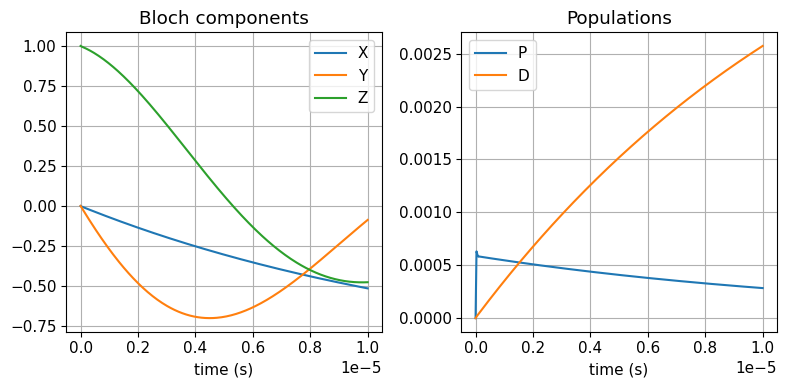

In [ ]:
Omega = 2*np.pi * 1e6        # single-photon Rabi [rad/s]
Delta = 2*np.pi * 20e6      # detuning [rad/s]
phi1 = -np.pi/2             # phase for first pulse (to move towards X)
phi2 = 0.0                  # phase for second pulse (to move towards Y)

q = IonQubit('0')
rho0 = q.state.copy().tocsr()  # type: ignore
d = int(rho0.shape[0])
Omega_eff = (Omega * Omega) / (2.0 * Delta)
t_pi2 = (np.pi/2) / Omega_eff  # π/2 time in the effective two-level picture

HRam_1 = q.H_raman(Omega, phi1, Omega, phi1, Delta)  # first pulse (φ = -π/2)
HRam_2 = q.H_raman(Omega, phi2, Omega, phi2, Delta)  # second pulse (φ = 0)

g1 = Gate(H=HRam_1, duration=t_pi2, envelope="rect", phase_fn=make_const_phase(0.0), turn_on=0.0)


omegaZ = q.omega_z_ac_stark(Delta=Delta, Omega1=Omega, Omega2=Omega, alpha0=1.0, alpha1=0.98)
phiZ = np.pi/2
tZ = phiZ / omegaZ
HZ   = q.H_z_from_ac_stark(Delta, Omega, Omega, 1.0, 0.98)
# gZ   = Gate(H=HZ, duration=tZ, envelope="rect", phase_fn=None, turn_on=t_pi2)
# g2 = Gate(H=HRam_2, duration=t_pi2, envelope="rect", phase_fn=make_const_phase(0.0), turn_on=t_pi2)


gamma_total = float(q.gamma_P)
bD = 0.005     # branching to D orbital
bS = (1-bD)/2  # branching to S
C0 = np.sqrt(gamma_total * bS) * q._0_P  # |0><P|
C1 = np.sqrt(gamma_total * bS) * q._1_P  # |1><P|
CD = np.sqrt(gamma_total * bD) * q._D_P  # |D><P|
c_ops = [C0.tocsr(), C1.tocsr(), CD.tocsr()]

T_total = t_pi2
N = 5001
tlist = np.linspace(0.0, T_total, N)

td_hams = [g.as_td() for g in [g1]]

t_out, rhos = simulate(state=rho0, c_hamiltonians=[], td_hamiltonians=td_hams,
                       c_ops=c_ops, tlist=tlist, n_savepoints=300, mode="rk4")


sx_qub, sy_qub, sz_qub = q.paulis()
B = np.stack([bloch_from_rho_qubit(r, sx_qub, sy_qub, sz_qub) for r in rhos])
norms = np.linalg.norm(B, axis=1)

print(norms)

pP = np.array([np.real((r @ q.PP).diagonal().sum()) for r in rhos])
pD = np.array([np.real((r @ q.PD).diagonal().sum()) for r in rhos])

print("t_pi2 (estimated) = {:.3e} s".format(t_pi2))
print("First Bloch (x,y,z) =", B[0])
print("Final Bloch (x,y,z) =", B[-1])
print("Final Bloch norm =", norms[-1])
print("Max excited-state population during sequence (P):", pP.max())

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_out, B[:,0], label='X'); plt.plot(t_out, B[:,1], label='Y'); plt.plot(t_out, B[:,2], label='Z')
plt.xlabel('time (s)'); plt.title('Bloch components'); plt.legend()
plt.subplot(1,2,2)
plt.plot(t_out, pP, label='P'); plt.plot(t_out, pD, label='D')
plt.xlabel('time (s)'); plt.title('Populations'); plt.legend()
plt.tight_layout()
plt.show()

In [5]:
def bloch_vectors_over_time(states, sx, sy, sz):
    return np.stack([bloch_from_rho_qubit(r, sx, sy, sz) for r in states])

def populations_PD_over_time(states, P_P, P_D):
    P = np.array([ (r @ P_P).diagonal().sum().real for r in states ])
    D = np.array([ (r @ P_D).diagonal().sum().real for r in states ])
    return P, D

B_id = bloch_vectors_over_time(rhos, sx_qub, sy_qub, sz_qub)
norm_id = np.linalg.norm(B_id, axis=1)

P_P = q.PP; P_D = q.PD
pP_id, pD_id = populations_PD_over_time(rhos, P_P, P_D)

lid = norm_id[-1]

print("Initial Bloch (ideal):", B_id[0])
print("Final   Bloch (ideal):", B_id[-1])
print("Final Bloch vector length:", lid)

Initial Bloch (ideal): [0. 0. 1.]
Final   Bloch (ideal): [-0.51491223 -0.08727167 -0.47649809]
Final Bloch vector length: 0.7069663237851757


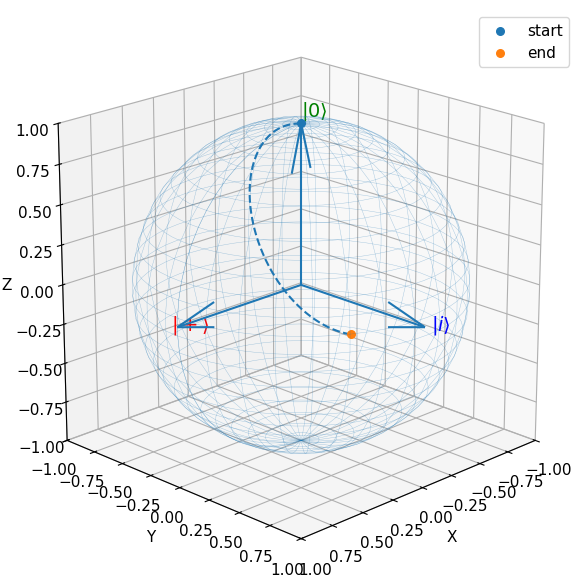

In [6]:
def plot_bloch_path(B, label="trajectory"):
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(xs, ys, zs, linewidth=0.3, alpha=0.4)

    # Add labels instead of points
    ax.text(1.05, 0, 0, r'$|+\rangle$', color='red', fontsize=14)
    ax.text(0, 0, 1.05, r'$|0\rangle$', color='green', fontsize=14)
    ax.text(0, 1.05, 0, r'$|i\rangle$', color='blue', fontsize=14)

    # Draw axes
    ax.quiver(0,0,0,1,0,0,length=1)
    ax.quiver(0,0,0,0,1,0,length=1)
    ax.quiver(0,0,0,0,0,1,length=1)

    # Plot trajectory
    ax.plot(B[:,0], B[:,1], B[:,2], linestyle="--")
    ax.scatter([B[0,0]],[B[0,1]],[B[0,2]], s=30, label='start')
    ax.scatter([B[-1,0]],[B[-1,1]],[B[-1,2]], s=30, label='end')

    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_box_aspect([1,1,1])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

    # Rotate view so x,y point toward viewer
    ax.view_init(elev=20, azim=45)   # tweak azim to adjust

    ax.legend()
    plt.tight_layout()
    plt.show()

plot_bloch_path(B_id, label="ideal")
